In [33]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

df: DataFrame = pd.read_csv(".//static//csv//Yamana_Gold_Inc._AUY.csv")

## Формирование базы нечетких правил
Сформируем базу нечетких правил, которые связывают входные и выходные переменные.

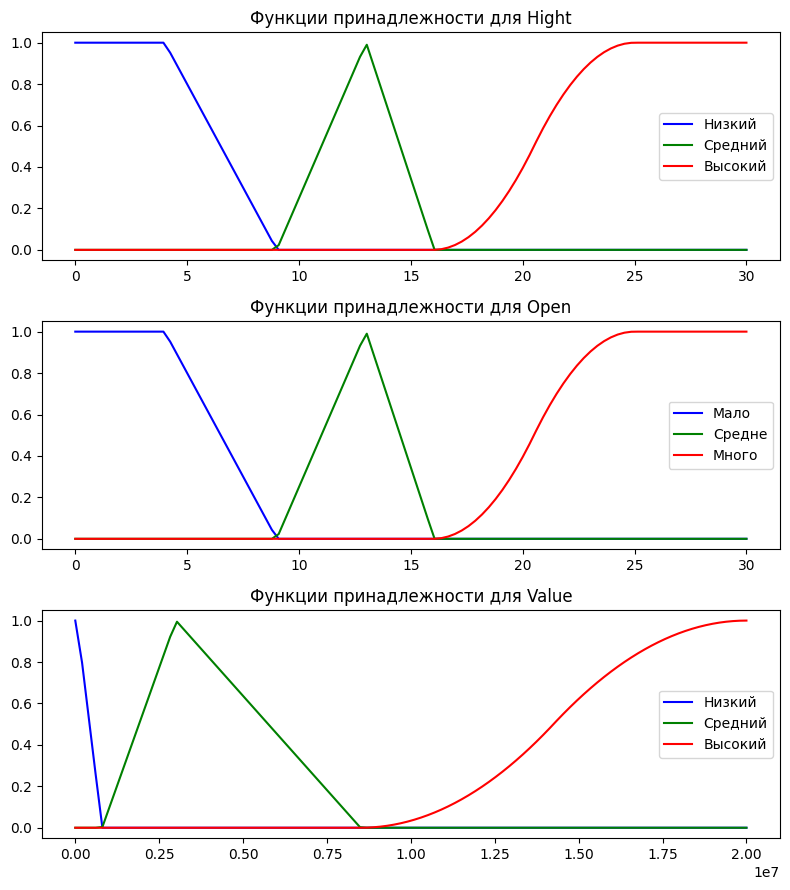

In [34]:
# Определение диапазонов значений для входных переменных
x_high = np.linspace(0, 30, 100)
x_open = np.linspace(0, 30, 100)
x_volume = np.linspace(0, 20000000, 100)

# Определение функций принадлежности для high
high_low = fuzz.trapmf(x_high, [0, 0, 4, 9.005])
high_medium = fuzz.trimf(x_high, [9, 13, 16.05])
high_high = fuzz.smf(x_high, 16, 25)

# Определение функций принадлежности для Open
open_low = fuzz.trapmf(x_open, [0, 0, 4, 9.005])
open_medium = fuzz.trimf(x_open, [9, 13, 16.05])
open_high = fuzz.smf(x_open, 16, 25)

# Определение функций принадлежности для Value
volume_low = fuzz.trapmf(x_volume, [0, 0, 50000, 800050])
volume_medium = fuzz.trimf(x_volume, [800000, 3000000, 8500050])
volume_high = fuzz.smf(x_volume, 8500000, 20000000)

# Определение нечетких правил
fuzzy_rules = [
    ("Низкий", "Мало", "Низкий"),
    ("Низкий", "Средне", "Средний"),
    ("Низкий", "Много", "Высокий"),
    ("Средний", "Мало", "Средний"),
    ("Средний", "Средне", "Высокий"),
    ("Средний", "Много", "Высокий"),
    ("Высокий", "Мало", "Высокий"),
    ("Высокий", "Средне", "Высокий"),
    ("Высокий", "Много", "Высокий")
]

# Визуализация функций принадлежности
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

ax0.plot(x_high, high_low, 'b', linewidth=1.5, label='Низкий')
ax0.plot(x_high, high_medium, 'g', linewidth=1.5, label='Средний')
ax0.plot(x_high, high_high, 'r', linewidth=1.5, label='Высокий')
ax0.set_title('Функции принадлежности для Hight')
ax0.legend()

ax1.plot(x_open, open_low, 'b', linewidth=1.5, label='Мало')
ax1.plot(x_open, open_medium, 'g', linewidth=1.5, label='Средне')
ax1.plot(x_open, open_high, 'r', linewidth=1.5, label='Много')
ax1.set_title('Функции принадлежности для Open')
ax1.legend()

ax2.plot(x_volume, volume_low, 'b', linewidth=1.5, label='Низкий')
ax2.plot(x_volume, volume_medium, 'g', linewidth=1.5, label='Средний')
ax2.plot(x_volume, volume_high, 'r', linewidth=1.5, label='Высокий')
ax2.set_title('Функции принадлежности для Value')
ax2.legend() 

plt.tight_layout()
plt.show()

## База нечётких правил




Для оценки качества системы создадим тестовые данные и применим нечеткие правила для получения предсказанных значений. Затем сравним их с реальными значениями.

In [35]:
# Функция для вычисления нечеткой оценки
def fuzzy_inference(high, open):
    # Определение степени принадлежности
    high_low_degree = fuzz.interp_membership(x_high, high_low, high)
    high_medium_degree = fuzz.interp_membership(x_high, high_medium, high)
    high_high_degree = fuzz.interp_membership(x_high, high_high, high)

    open_low_degree = fuzz.interp_membership(x_open, open_low, open)
    open_medium_degree = fuzz.interp_membership(x_open, open_medium, open)
    open_high_degree = fuzz.interp_membership(x_open, open_high, open)

    # Применяем правила
    # Активируем термы выходной переменной с использованием степени принадлежности
    volume_low_activated = np.fmin(high_low_degree, volume_low)
    volume_medium_activated = np.fmin(high_medium_degree, volume_medium)
    volume_high_activated = np.fmin(high_high_degree, volume_high)

    # Агрегируем все активированные термы
    aggregated = np.fmax(volume_low_activated, np.fmax(volume_medium_activated, volume_high_activated))

    # Дефуззификация
    volume_defuzz = fuzz.defuzz(x_volume, aggregated, 'centroid')

    return volume_defuzz

# Оценка системы на тестовом наборе данных
results = []
test_data = [
    (10.26, 10.39, 10532700),
    (3.65, 3.75, 581100),
    (3.74, 3.89, 522100),
    (3.94, 3.95, 427100),
    (3.65, 3.68, 383500),
]
for high, open,  actual_volume in test_data:
    inferred_volume = fuzzy_inference(high, open)
    results.append((high, open, actual_volume, inferred_volume))

# Вывод результатов
print("High | Open | Value | Оцененная Value")
for high, open, actual_volume, inferred_volume in results:
    print(f"{high:4} | {open:6} | {actual_volume:15} | {inferred_volume:.2f}")

# Вычисление метрик качества
actual_volumes = [actual for _, _, actual, _ in results]
inferred_volumes = [inferred for _, _, _, inferred in results]

mae = np.mean(np.abs(np.array(actual_volumes) - np.array(inferred_volumes)))
rmse = np.sqrt(np.mean((np.array(actual_volumes) - np.array(inferred_volumes)) ** 2))

print(f"\nСредняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Среднеквадратичная ошибка (RMSE): {rmse:.2f}")

High | Open | Value | Оцененная Value
10.26 |  10.39 |        10532700 | 4408286.95
3.65 |   3.75 |          581100 | 271034.51
3.74 |   3.89 |          522100 | 271034.51
3.94 |   3.95 |          427100 | 271039.24
3.65 |   3.68 |          383500 | 271034.51

Средняя абсолютная ошибка (MAE): 1390814.06
Среднеквадратичная ошибка (RMSE): 2746074.04


В результате выполнения лабораторной работы была создана нечеткая система, которая позволяет оценивать общую стоимость транзакции на основе открытия золота и количества продаж золота. Система была протестирована на тестовых данных, и были вычислены метрики качества (MAE и RMSE). Полученные результаты указывают на необходимость дальнейшей настройки системы для повышения точности предсказаний.